# Plots about Roberta

In [1]:
cd ..

/data


In [2]:
import pickle, itertools
import numpy as N
import pandas
import matplotlib.pyplot as pyplot
import seaborn
import language_models
import utils

paths = language_models.get_paths('roberta')

In [3]:
def grid_share_axes(axs, shareX=True, shareY=True):
    nRow = len(axs)
    nCol = len(axs[0])
    if shareX:
        [axs[0][j].get_shared_x_axes().join(*[axs[i][j] for i in range(nRow)])
         for j in range(nCol)]
        # Remove ticks
        [axs[i][j].set_xticklabels([])
         for i in range(nRow-1)
         for j in range(nCol)]
    if shareY:
        [axs[i][0].get_shared_y_axes().join(*[axs[i][j] for j in range(nCol)])
         for i in range(nRow)]
        [axs[i][j].set_yticklabels([])
         for i in range(nRow)
         for j in range(1,nCol)]
def label_right(axs_row, label):
    """
    Use in conjunction as the above
    """
    ax = axs_row[-1]
    ax.set_ylabel(label)
    ax.yaxis.set_label_position("right")
    ax.yaxis.tick_right()
    

## Cosine Gradient Plot

In [4]:
source = 'roberta-base'
with open(paths['plots'] / f'{source}-gradCosine.pickle', 'rb') as f:
    gradCosines = pickle.load(f)

# Print example keys
print(gradCosines[1])

['backbone.roberta.encoder.layer.0.attention.self.query.weight', 'backbone.roberta.encoder.layer.0.attention.self.query.bias', 'backbone.roberta.encoder.layer.0.attention.self.key.weight', 'backbone.roberta.encoder.layer.0.attention.self.key.bias', 'backbone.roberta.encoder.layer.0.attention.self.value.weight', 'backbone.roberta.encoder.layer.0.attention.self.value.bias', 'backbone.roberta.encoder.layer.0.attention.output.dense.weight', 'backbone.roberta.encoder.layer.0.attention.output.dense.bias', 'backbone.roberta.encoder.layer.0.attention.output.LayerNorm.weight', 'backbone.roberta.encoder.layer.0.attention.output.LayerNorm.bias', 'backbone.roberta.encoder.layer.0.intermediate.dense.weight', 'backbone.roberta.encoder.layer.0.intermediate.dense.bias', 'backbone.roberta.encoder.layer.0.output.dense.weight', 'backbone.roberta.encoder.layer.0.output.dense.bias', 'backbone.roberta.encoder.layer.0.output.LayerNorm.weight', 'backbone.roberta.encoder.layer.0.output.LayerNorm.bias', 'backbo

### Cosine Rankings (averaged across history)

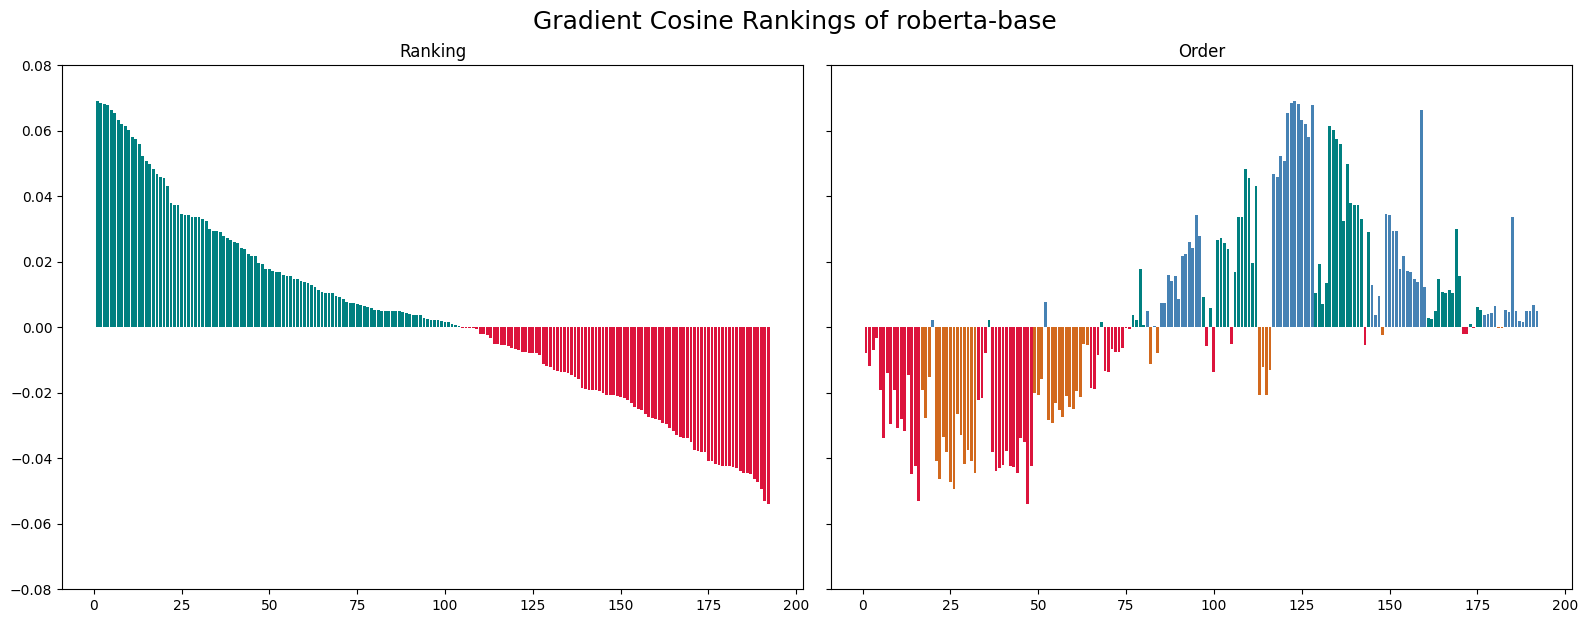

In [11]:
fig, axs = pyplot.subplots(1, 2, figsize=(16,6))

def to_layer(name, score):
    name = name.split('.')
    if name[2] == 'encoder':
        return f'{name[2]}.{name[4]}'
    if name[2] == 'decoder':
        return f'{name[2]}.{name[4]}'
    
    return name[2]
def to_color(score, alternate):
    if score > 0:
        return 'teal' if alternate % 2 == 0 else 'steelblue'
    else:
        return 'crimson' if alternate % 2 == 0 else 'chocolate'

gc, keys = gradCosines
scores = gc.mean(axis=0)
minScore, maxScore = scores.min(), scores.max()

df = pandas.DataFrame({'Rank': range(1,scores.size+1),
                       'Sorted': sorted(list(scores), reverse=True),
                       'Unsorted': scores,
                       'Layer': [to_layer(n,s) for n,s in zip(keys,scores)]})
layerLookup = [k for k, _group in itertools.groupby(df['Layer'])]
layerLookup = {k:i for i,k in enumerate(layerLookup)}
df['Alternate'] = [layerLookup[l] for l in df['Layer']]
df['Color'] = [to_color(s, a) for s,a in zip(df['Unsorted'], df['Alternate'])]

ax = axs[0]
ax.bar(x=df['Rank'], height=df['Sorted'],
       color=['teal' if c > 0 else 'crimson' for c in df['Sorted']])
ax.set_ylim(-0.08, 0.08)
ax.set_title('Ranking')

ax = axs[1]
ax.bar(x=df['Rank'], height=df['Unsorted'], color=df['Color'])
ax.set_title('Order')
ax.set_ylim(-0.08, 0.08)

axs[0].get_shared_y_axes().join(axs[0], axs[1])
axs[1].set_yticklabels([])

fig.tight_layout()
fig.suptitle(f'Gradient Cosine Rankings of {source}', fontsize=18, y=1.03)
fig.savefig(paths['plots'] / 'roberta-gradient-cosine.png', dpi=300)

### Historical trends of the highest and lowest cosines

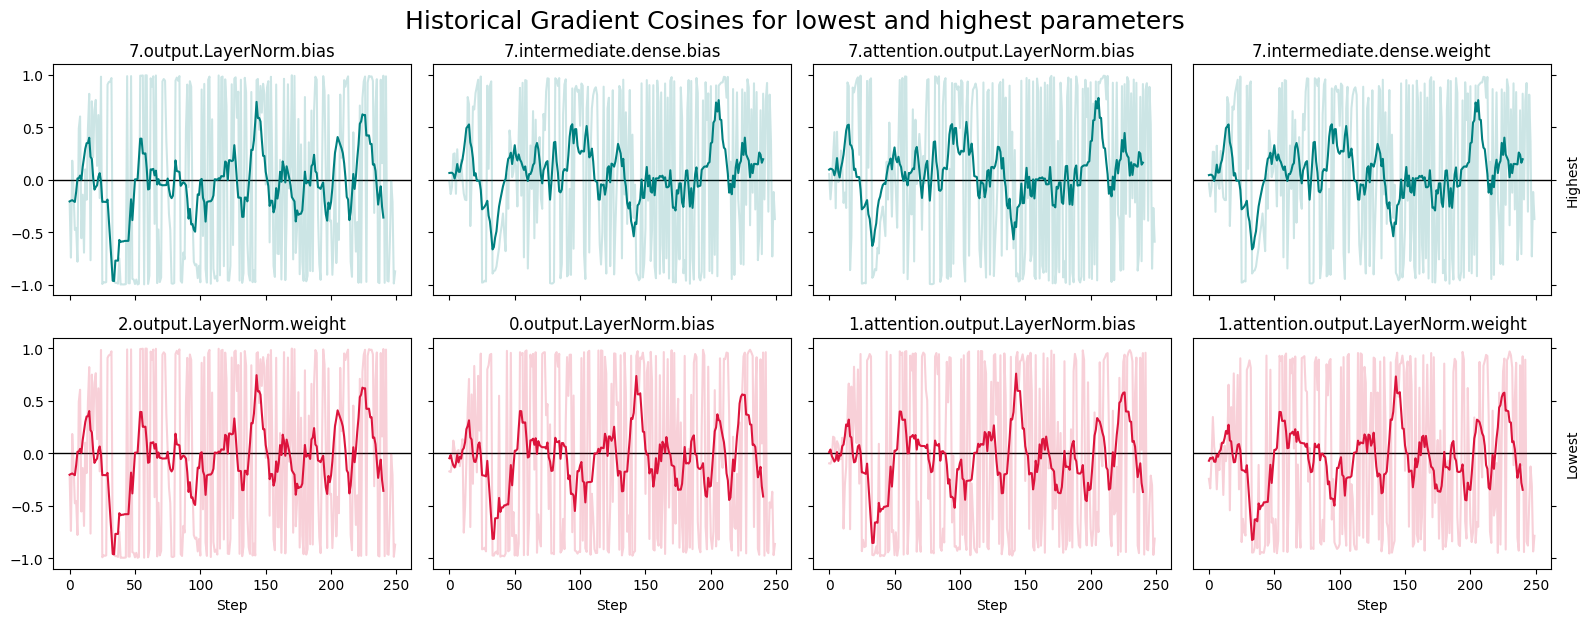

In [14]:
# plots
topN = 4
fig, axs = pyplot.subplots(2, topN, figsize=(4*topN, 6))

gc, keys = gradCosines
idxSorted = N.argsort(gc.mean(axis=0))
keysLowest = [keys[j] for j in idxSorted[:topN]]
keysHighest = [keys[j] for j in idxSorted[-topN:]]

def format_key(k):
    k = k.split('.')
    k = k[4:]
    return '.'.join(k)

for i,(kL,kH) in enumerate(zip(keysLowest, keysHighest)):
    # Plot the historic trends
    j = idxSorted[-i]
    ax = axs[0][i]
    ax.axhline(y=0, xmin=0.0, xmax=1.0, color='k', linewidth=1)
    ax.plot(gc[:,j], color='teal', alpha=0.2)
    ax.plot(utils.smooth(gc[:,j], filter_size=10), color='teal')
    ax.set_ylim([-1.1, 1.1])
    ax.set_title(format_key(kH))
    
    j = idxSorted[i]
    ax = axs[1][i]
    ax.set_xlabel('Step')
    ax.axhline(y=0, xmin=0.0, xmax=1.0, color='k', linewidth=1)
    ax.plot(gc[:,j], color='crimson', alpha=0.2)
    ax.plot(utils.smooth(gc[:,j], filter_size=10), color='crimson')
    ax.set_ylim([-1.1, 1.1])
    ax.set_title(format_key(kL))
    

grid_share_axes(axs)
label_right(axs[0], 'Highest')
label_right(axs[1], 'Lowest')

fig.tight_layout()
fig.suptitle(f'Historical Gradient Cosines for lowest and highest parameters', fontsize=18, y=1.03)
fig.savefig(paths['plots'] / 'roberta-gradient-cosine-hist.png', dpi=300)

## Training Plots

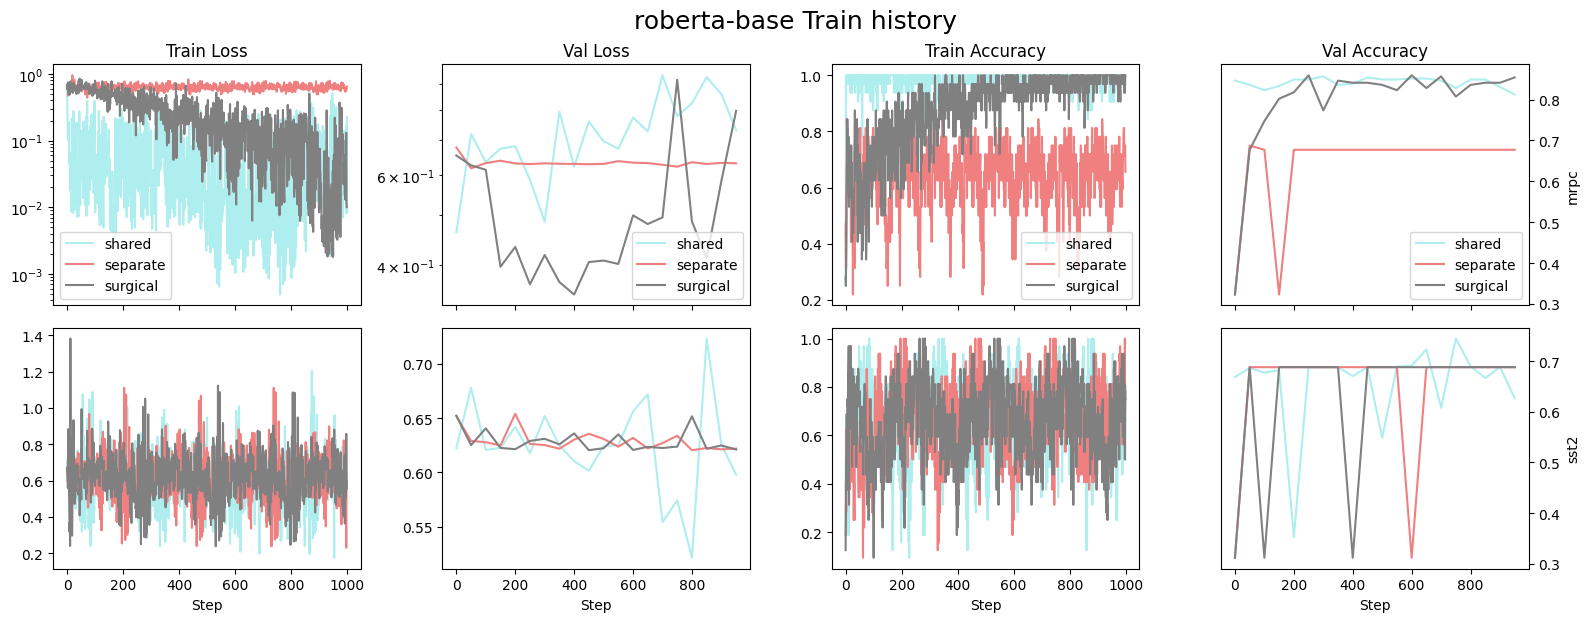

In [16]:

def plot_single_model(source):
    TOPOLOGIES = [
        ('shared', 'paleturquoise'),
        ('separate', 'lightcoral'),
        ('surgical', 'grey')
    ]
    TASKS = ['mrpc', 'sst2']
    losses = dict()
    metrics = dict()
    eval_losses = dict()
    eval_metrics = dict()
    
    def transform_input(x):
        # Convert list of (step, {}) -> {k: [ ... ]}
        # effectively a transposition
        keys = x[0][1].keys()
        return {k:[(s,val[k]) for s,val in x]
                for k in keys}
    
    for top,_ in TOPOLOGIES:

        with open(paths['plots'] / f"{source}-{top}.pickle", "rb") as f:
            exp = pickle.load(f)
            losses[top] = transform_input(exp[0])
            metrics[top] = transform_input(exp[1])
            eval_losses[top] = transform_input(exp[2])
            eval_metrics[top] = transform_input(exp[3])
            
    
    fig, axs = pyplot.subplots(len(TASKS), 4, figsize=(16, len(TASKS)*3))
    for iTask,task in enumerate(TASKS):
        for iTop,(top,color) in enumerate(TOPOLOGIES):
        
            # plot
            ax = axs[iTask][0]
            tl_x, tl_y = zip(*losses[top][task])
            ax.plot(tl_x, tl_y, label=f'{top}', color=color)
            

            ax = axs[iTask][1]
            el_x, el_y = zip(*eval_losses[top][task])
            ax.plot(el_x, el_y, label=f'{top}', color=color)
            

            ax = axs[iTask][2]
            tm_x, tm_y = zip(*metrics[top][task])
            ax.plot(tm_x, tm_y, label=f'{top}', color=color)
            #ax.set_ylim([0.95, 0.999])
            

            ax = axs[iTask][3]
            em_x, em_y = zip(*eval_metrics[top][task])
            ax.plot(em_x, em_y, label=f'{top}', color=color)
            #ax.set_ylim([0.95, 0.999])
            
        label_right(axs[iTask], task)
        
    for i in range(4):
        ax = axs[0][i]
        ax.legend()
        ax = axs[1][i]
        ax.set_xlabel('Step')
        
    ax = axs[0][0]
    ax.set_title('Train Loss')
    ax.set_yscale('log')
    ax = axs[0][1]
    ax.set_title('Val Loss')
    ax.set_yscale('log')
    ax = axs[0][2]
    ax.set_title('Train Accuracy')
    ax = axs[0][3]
    ax.set_title('Val Accuracy')
    
    grid_share_axes(axs, shareX=True, shareY=False)
    
    fig.tight_layout()
    fig.suptitle(f'{source} Train history', fontsize=18, y=1.03)
    fig.savefig(paths['plots'] / f'{source}-hist.png', dpi=300)
    
plot_single_model('roberta-base')